# Source-side MTUQ moment tensor estimations using SPECFEM3D_Globe-generated 3D Green's Functions
 
[MTUQ has the capability of reading Green's Functions](https://uafgeotools.github.io/mtuq/user_guide/03.html) calculated in Specfem3D to incorporate 3D velocity models for moment tensor estimation.
 
Here, we guide you through the process of creating a 3D Green's Function (GF) database using SPECFEM3D_Globe for an example event in Alaska.
This process is computationally costly, so while we provide the process and scripts for SPECFEM3D_Globe, we also provide the GF database for you.

Finally, we run an inversion in MTUQ using the generated GF database, and compare it to the 1D result.
 
This process is fundamentally the same as generating GF databases from SPECFEM3D_Cartesian, but much of the pre-processing is taken care of in SPECFEM3D_Globe for free. 
Things such as rotating the synthetic seismograms from ENZ to RTZ, and saving the synthetics as SAC files are allowed within SPECFEM3D_Globe, and are expected for use in MTUQ.

## Generating source-side 3D Green's Functions using SPECFEM3D_Globe

We assume you know something of how to use SPECFEM3D, but if you do not there was a [SPECFEM User's Workshop](https://sites.google.com/alaska.edu/carltape/home/research/specfem2022?authuser=0), and all the [material is still available](https://github.com/adjtomo/adjdocs/tree/main/workshops/2022-10-05_specfem_users).
While the tutorials covered SPECFEM2D and SPECFEM3D_Cartesian, the workflow for SPECFEM3D_Globe is similar and in some ways easier.

The general steps for generating a source-side GF database in SPECFEM3D_Globe as as follows:
                                                                                     
- **Mesh Generation:** Define your area of interest in the Par_file and run xmeshfem3D
- **Run the Solver:** For each of the 6 elementary sources of a moment tensor, run the forward simulation using xspecfem3D
- **Output Files:** Rename the output files and organize the data directory structure for use in MTUQ
                                                                                     
The first two steps are, as we said, computationally costly, running on 160 and 960 cores respectively on the Chinook HPC at the University of Alaska Fairbanks.
However, the Par_file and directory structure can be illuminating, so we have provided an example working directory for this example.
        

### Investigating the directory structure in SPECFEM3D_Globe

For this sort of simulation, we take advantage of SPECFEM3D's ability to run simultaneous simulations and broadcast the same mesh to them all. This changes the base directory structure from:

- **bin**
    - xmeshfem3D
    - xspecfem3D
- **DATA**
    - Par_file
    - STATIONS
    - CMTSOLUTION
    - Velocity Model Directory
    - Crustal Model Directory
    - Topography Model Directory
- **DATABASES**
    - *Empty to start*
- **OUTPUT_FILES**
    - *Empty to start*
    
To:

- **bin**
    - xmeshfem3D
    - xspecfem3D
- **DATA**
    - Par_file
    - Velocity Model Directory
    - Crustal Model Directory
    - Topography Model Directory
- **DATABASES**
    - *Empty to start*
- **OUTPUT_FILES**
    - *Empty to start*
- **run0001**
    - DATA
        - STATIONS
        - CMTSOLUTION
            - *One of the fundamental sources for a moment tensor*
    - DATABASES
        - *Symbolically linked to* **DATABASES**
    - OUTPUT_FILES
        - *Contains NT.STA.BX?.sem.sac files*
- **run0002**
    - DATA
        - STATIONS
        - CMTSOLUTION
            - *One of the fundamental sources for a moment tensor
    - DATABASES
        - *Symbolically linked to* **DATABASES**
    - OUTPUT_FILES
        - *Contains NT.STA.BX?.sem.sac files*
- **run0003**
    - DATA
        - STATIONS
        - CMTSOLUTION
            - *One of the fundamental sources for a moment tensor*
    - DATABASES
        - *Symbolically linked to* **DATABASES**
    - OUTPUT_FILES
        - *Contains NT.STA.BX?.sem.sac files*
- **run0004**
    - DATA
        - STATIONS
        - CMTSOLUTION
            - *One of the fundamental sources for a moment tensor*
    - DATABASES
        - *Symbolically linked to* **DATABASES**
    - OUTPUT_FILES
        - *Contains NT.STA.BX?.sem.sac files*
- **run0005**
    - DATA
        - STATIONS
        - CMTSOLUTION
            - *One of the fundamental sources for a moment tensor*
    - DATABASES
        - *Symbolically linked to* **DATABASES**
    - OUTPUT_FILES
        - *Contains NT.STA.BX?.sem.sac files*
- **run0006**
    - DATA
        - STATIONS
        - CMTSOLUTION
            - *One of the fundamental sources for a moment tensor*
    - DATABASES
        - *Symbolically linked to* **DATABASES**
    - OUTPUT_FILES
        - *Contains NT.STA.BX?.sem.sac files*

Of special note are the CMTSOLUTION files: each one corresponds to one of the 6 Mij required to construct synthetic seismograms. A Green's Function is a response to a unit impulse, but you can see that each Mij is 1e22. This is a somewhat arbitrary number, but it needs to be large enough to prevent numerical instability in the forward simulation. Later, we will simply divide the synthetics by 1e22 to arrive at a unit impulse.

### Running SPECFEM3D_Globe

The procedure for using SPECFEM3D_Globe is as follows:

- Run the mesher **meshfem3D** using NUMBER_OF_SIMULTANEOUS_RUNS = 1 in DATA/Par_file
- Run the solver **specfem3D** using NUMBER_OF_SIMULTANEOUS_RUNS = 6 in DATA/Par_file

If you change any other parameter in between, you **must re-run the mesher**. Otherwise, the solver will fail. The SPECFEM3D_Globe work directory is set up right now to run the mesher on your HPC of choice. On the [Chinook HPC system at the University of Alaska](https://uaf-rcs.gitbook.io/uaf-rcs-hpc-docs/hpc), the mesher runs in approximately 2.5 minutes on 160 cores, and the solver finishes in 45 minutes on 960 cores.

If you do not care to run SPECFEM3D_Globe, the GFs have already been produced and you can run the organizing script without running SPECFEM3D_Globe.

### Organizing and re-scaling Green's Functions

What's listed above is what is required for SPECFEM to run. We include in each run directory a blank text file {Mij}.txt to keep the GFs organized. The script below will read that text file to create the directory structure that MTUQ requires for a GF database. It will also scale the GFs in the following manner to arrive at the appropriate units for MTUQ to use: 

- Output displacement units from SPECFEM_Globe are always in meters
- We divide the output by the dyne-cm value used in the **CMTSOLUTION**, giving units of $ \frac{m}{dyne-cm} $
    - As stated previously, we standardly use Mij values of 1e22 in our **CMTSOLUTIONS**
- MTUQ expects units of $ \frac{m}{N-m} $, so next we multiply by 1e7 $ \frac{dyne-cm}{N-m} $
- This process is simplified in the script below by dividing each GF by 1e15

In [ ]:
%run -i 'organize_scale_sac.py'

## Using SPECFEM_Globe-generated 3D Green's Functions in MTUQ 

At this point in the Notebook, we now have our 3D GF database ready for use in MTUQ. The event we have chosen is the 2009 Southern Alaska event used in the examples provided in MTUQ. The two examples in particular we will compare are GridSearch.DoubleCouple.py and GridSearch.FullMomentTensor.py. The results of each script are shown below.

**Double Couple Result**
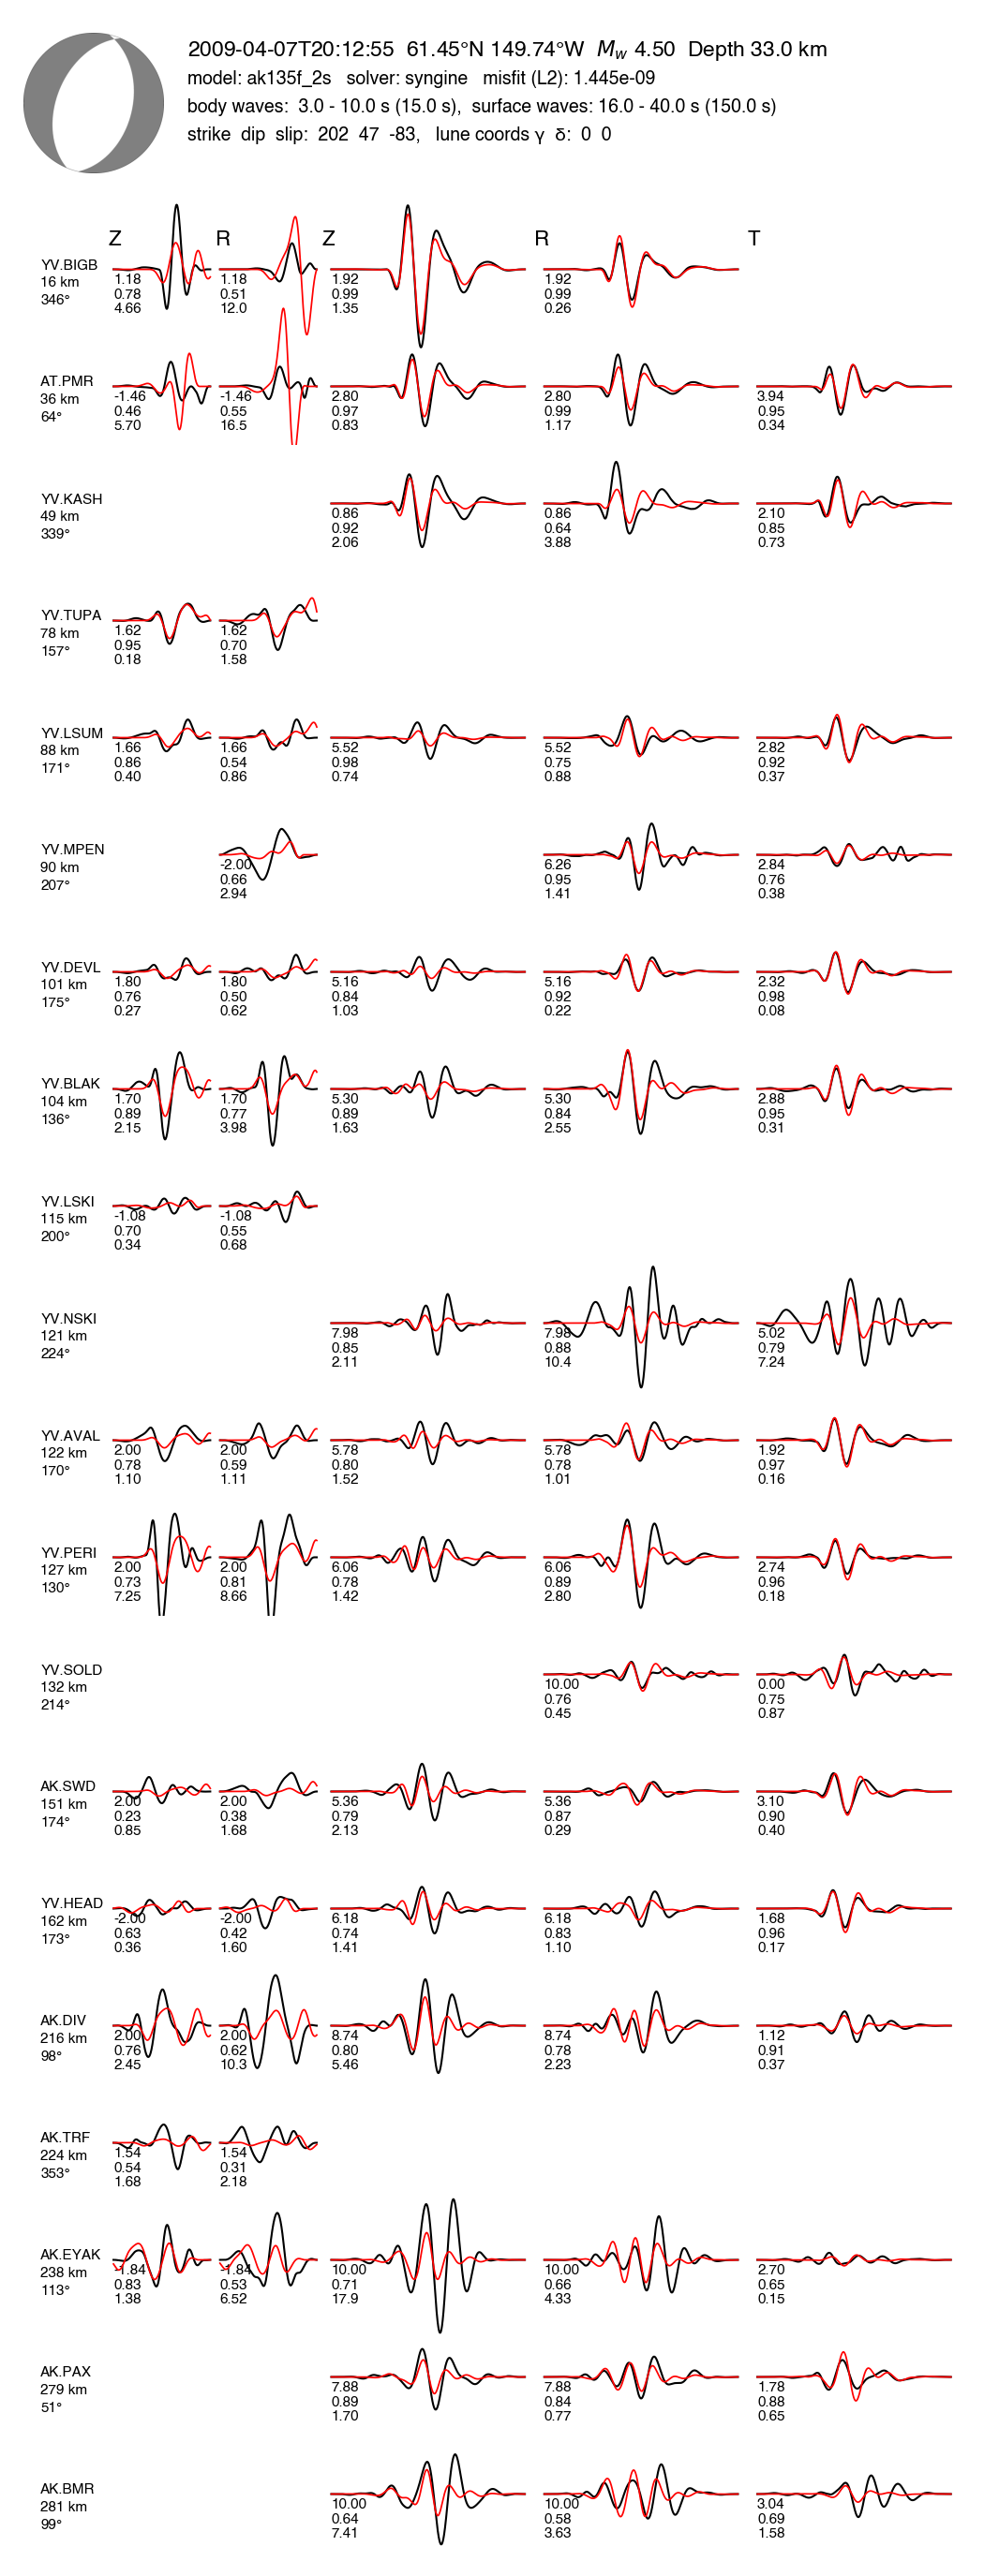

**Full Moment Tensor Result**
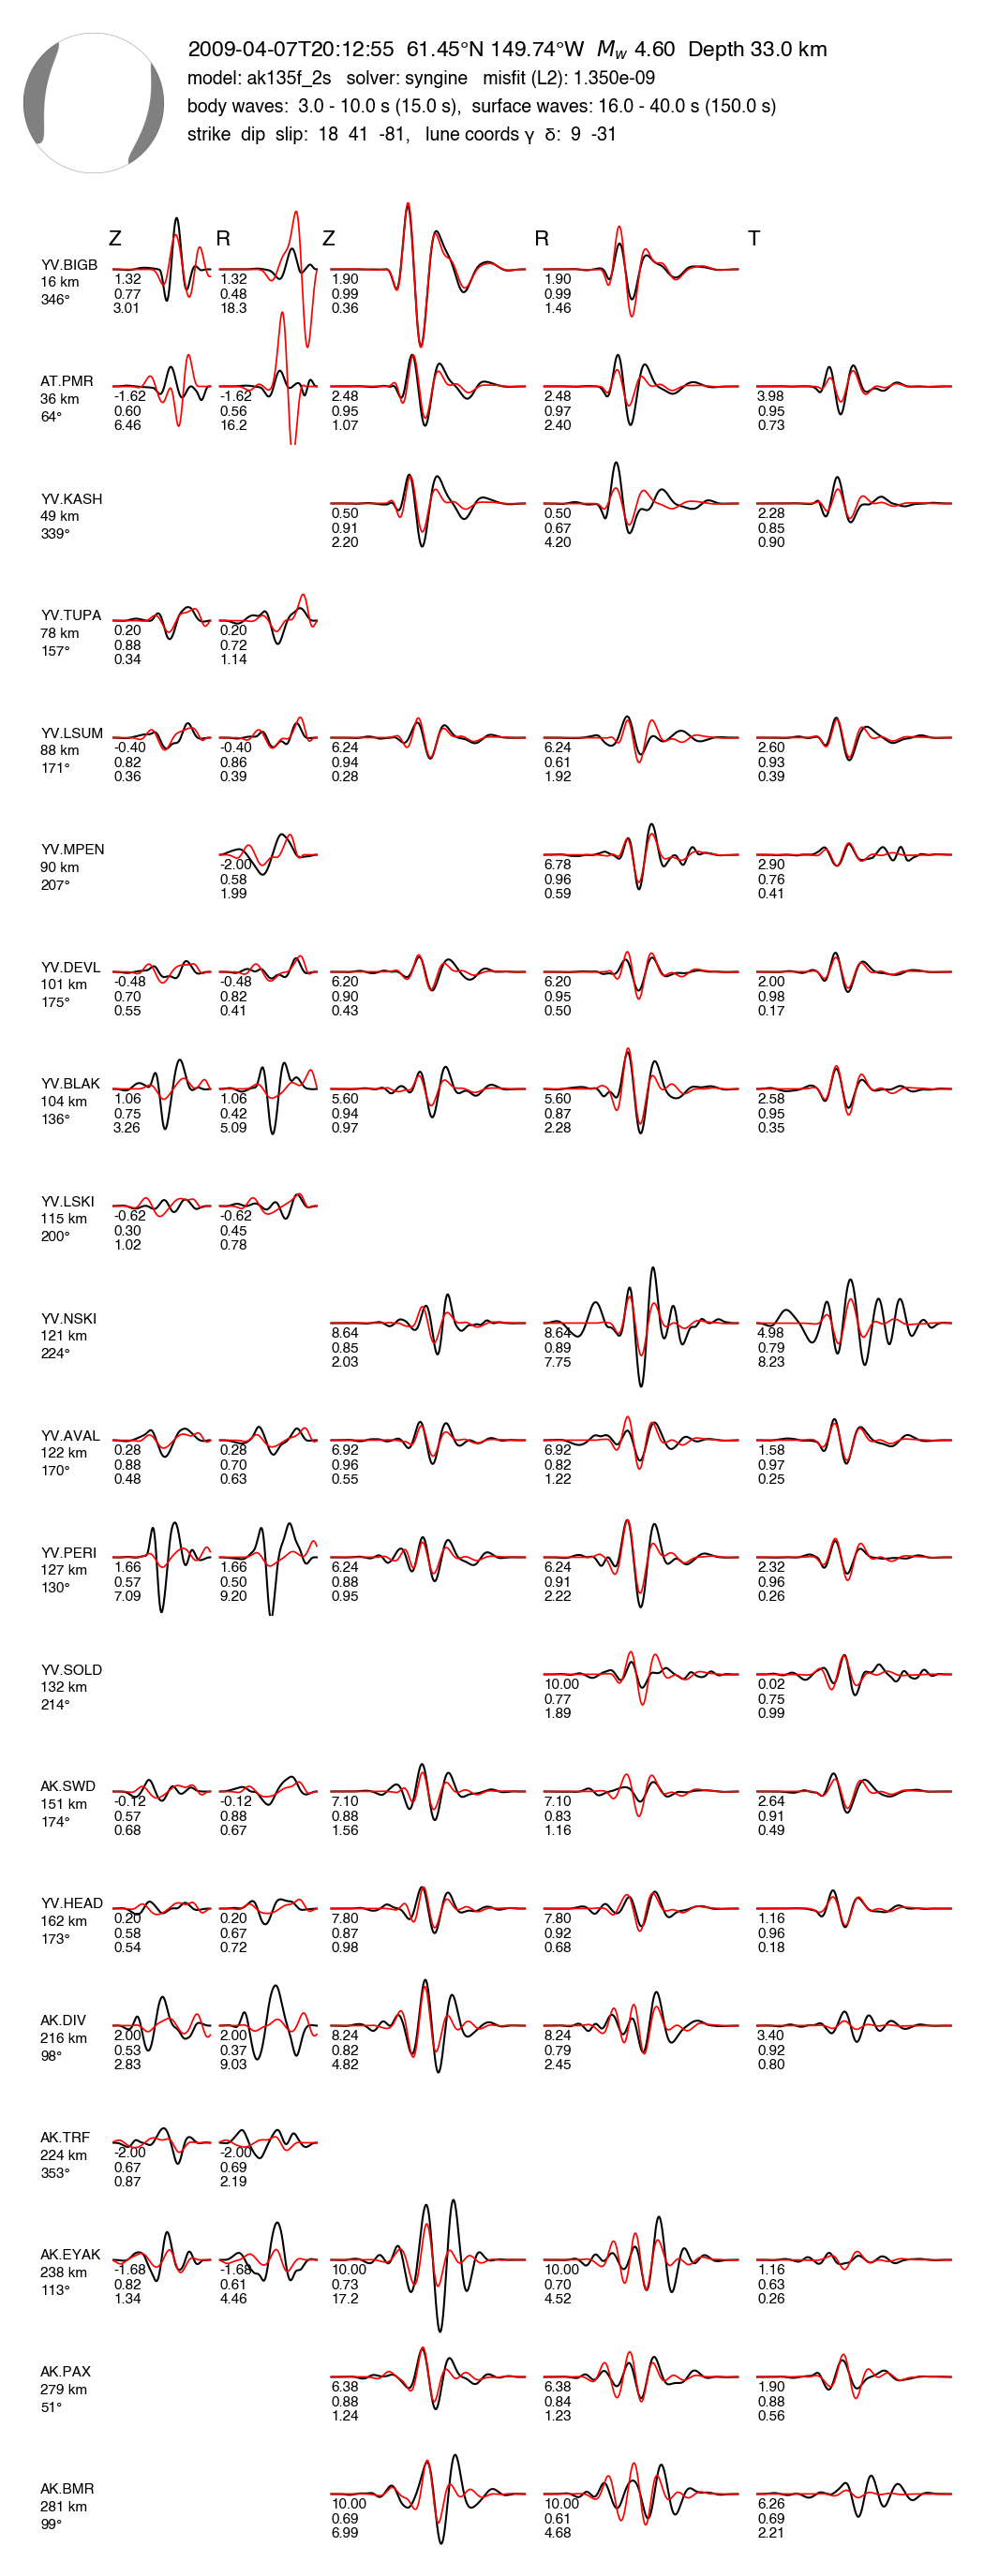

We have modified the example scripts that generated the above images to use the SPECFEM3D_Globe 3D Green's Functions, and provide them for you in this directory. You can run the cells below to use them; however, you must have the MTUQ Conda environment installed and active whilst using this Notebook.

In [ ]:
# Run this cell to see the double couple result
# Run time is approximately 60 seconds
from IPython import display

%run -i GridSearch.3D.DoubleCouple.py

display.Image('./20090407201255351DC_waveforms.png')

In [ ]:
# Run this cell to see the full moment tensor result
# Run time is approximately 3.5 minutes
%run -i GridSearch.3D.FullMomentTensor.py

display.Image('./20090407201255351FMT_waveforms.png')